# Graphormer Lab: Molecular Property Prediction

This notebook demonstrates a simplified Graphormer-style approach to molecular property prediction using the **Tox21** dataset from **MoleculeNet**. We'll:
1. Explore and visualize the dataset.
2. Define a simplified Graphormer model using Transformer-like layers.
3. Train and evaluate our model.

Make sure you have `torch-geometric` and `rdkit` installed, as well as `scikit-learn` for metric calculations.

## 1. Setup and Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.datasets import MoleculeNet
from torch_geometric.loader import DataLoader
from torch_geometric.nn import TransformerConv, global_mean_pool
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import roc_auc_score
import networkx as nx
from torch_geometric.utils import to_networkx

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cpu


## 2. Load and Explore the Dataset

Total molecules in Tox21: 7823
Data(x=[16, 9], edge_index=[2, 34], edge_attr=[34, 3], smiles='CCOc1ccc2nc(S(N)(=O)=O)sc2c1', y=[1, 12])


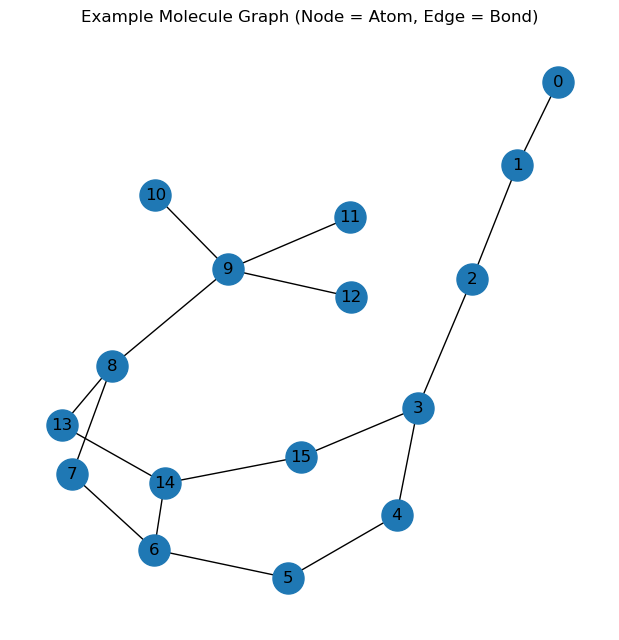

In [2]:
from torch_geometric.transforms import BaseTransform

class ReplaceNanLabelsTransform(BaseTransform):
    def __call__(self, data):
        # Replace any NaN in data.y with -1
        mask_nan = torch.isnan(data.y)
        data.y[mask_nan] = -1
        return data

# Load the Tox21 dataset
# Tox21 is a multi-task dataset with 12 different molecular toxicity labels.
dataset = MoleculeNet(root='./data', name='Tox21', transform=ReplaceNanLabelsTransform())
print(f'Total molecules in Tox21: {len(dataset)}')

# Inspect the first example
data_example = dataset[0]
print(data_example)

# Visualize the graph structure of the first molecule
G = to_networkx(data_example, to_undirected=True)
plt.figure(figsize=(6,6))
nx.draw(G, with_labels=True, node_size=500)
plt.title('Example Molecule Graph (Node = Atom, Edge = Bond)')
plt.show()

### Train/Test Split

We'll split the dataset into a training portion and a test portion to evaluate generalization. You can also create a validation split if needed.

In [3]:
train_dataset = dataset[:5000]
test_dataset = dataset[5000:]

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Train set size: {len(train_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Train set size: 5000
Test set size: 2823


## 3. Define the Graphormer Model

Below is a simple version using PyTorch Geometric's `TransformerConv`. We stack two such layers (each using multiple attention heads) and then pool the resulting node embeddings for the final prediction.

In [4]:
class SimpleGraphormer(nn.Module):
    def __init__(self, num_node_features, hidden_dim, num_classes):
        super(SimpleGraphormer, self).__init__()
        # We'll use 4 heads for demonstration
        heads = 4

        self.conv1 = TransformerConv(
            in_channels=num_node_features,
            out_channels=hidden_dim,
            heads=heads,
            dropout=0.1,
            edge_dim=None  # For edge attributes if available
        )
        
        # The output dimension of conv1 is hidden_dim * heads
        self.conv2 = TransformerConv(
            in_channels=hidden_dim * heads,
            out_channels=hidden_dim,
            heads=heads,
            dropout=0.1,
            edge_dim=None
        )

        # Final linear layer for classification (Tox21 is multi-task with 12 tasks)
        self.classifier = nn.Linear(hidden_dim * heads, num_classes)

    def forward(self, x, edge_index, batch):
        # 1st TransformerConv
        x = self.conv1(x, edge_index)
        x = F.relu(x)

        # 2nd TransformerConv
        x = self.conv2(x, edge_index)
        x = F.relu(x)

        # Global mean pooling
        x = global_mean_pool(x, batch)

        # Final classification
        out = self.classifier(x)
        return out

## 4. Training Loop

We'll define a simple training function and run for a handful of epochs.

Epoch 1/1000, Loss: 0.3512
Epoch 2/1000, Loss: 0.2526
Epoch 3/1000, Loss: 0.2506
Epoch 4/1000, Loss: 0.2432
Epoch 5/1000, Loss: 0.2427
Epoch 6/1000, Loss: 0.2376
Epoch 7/1000, Loss: 0.2371
Epoch 8/1000, Loss: 0.2340
Epoch 9/1000, Loss: 0.2312
Epoch 10/1000, Loss: 0.2298
Epoch 11/1000, Loss: 0.2307
Epoch 12/1000, Loss: 0.2294
Epoch 13/1000, Loss: 0.2286
Epoch 14/1000, Loss: 0.2265
Epoch 15/1000, Loss: 0.2260
Epoch 16/1000, Loss: 0.2262
Epoch 17/1000, Loss: 0.2255
Epoch 18/1000, Loss: 0.2262
Epoch 19/1000, Loss: 0.2256
Epoch 20/1000, Loss: 0.2252
Epoch 21/1000, Loss: 0.2231
Epoch 22/1000, Loss: 0.2230
Epoch 23/1000, Loss: 0.2223
Epoch 24/1000, Loss: 0.2233
Epoch 25/1000, Loss: 0.2230
Epoch 26/1000, Loss: 0.2224
Epoch 27/1000, Loss: 0.2246
Epoch 28/1000, Loss: 0.2221
Epoch 29/1000, Loss: 0.2231
Epoch 30/1000, Loss: 0.2214
Epoch 31/1000, Loss: 0.2209
Epoch 32/1000, Loss: 0.2205
Epoch 33/1000, Loss: 0.2196
Epoch 34/1000, Loss: 0.2185
Epoch 35/1000, Loss: 0.2184
Epoch 36/1000, Loss: 0.2191
E

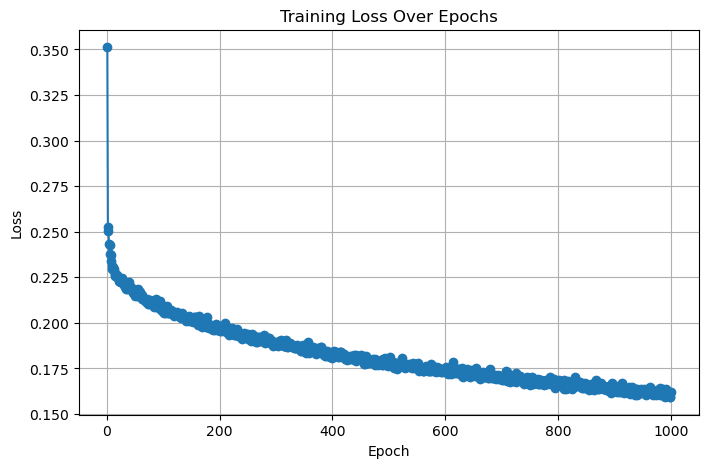

In [5]:
# Prepare the model
model = SimpleGraphormer(
    num_node_features=dataset.num_node_features,
    hidden_dim=64,
    num_classes=12  # Tox21 has 12 tasks
).to(device)

# We use BCEWithLogitsLoss for multi-task binary classification
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

def train(model, loader):
    model.train()
    total_loss = 0.0
    for data in loader:
        data = data.to(device)
        data.x = data.x.float()  # Ensure features are floats

        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)

        # Create a mask for valid labels (True where label != -1)
        mask = (data.y != -1)

        # Convert y to float
        y_float = data.y.float()

        # Count the number of valid labels in the batch
        valid_labels_count = mask.sum().item()

        if valid_labels_count == 0:
            # Skip batch if there are no valid labels
            continue

        # Weighted BCE loss where weight = 0 for invalid labels
        loss = torch.nn.functional.binary_cross_entropy_with_logits(
            out,
            y_float,
            weight=mask.float(),
            reduction='sum'
        )

        # Normalize the loss by the number of valid labels to avoid scaling issues
        loss = loss / valid_labels_count

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Return the average loss over batches
    return total_loss / len(loader)

# Train for a few epochs and record the training loss
EPOCHS = 1000
losses = []
for epoch in range(1, EPOCHS + 1):
    epoch_loss = train(model, train_loader)
    losses.append(epoch_loss)
    print(f"Epoch {epoch}/{EPOCHS}, Loss: {epoch_loss:.4f}")

# Plot the training loss curve
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(range(1, EPOCHS + 1), losses, marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

## 5. Evaluation

We use **ROC-AUC** (area under the ROC curve) to measure multi-task classification performance, averaging the results over all tasks while ignoring missing labels.

In [6]:
def evaluate(model, loader):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            data.x = data.x.float()  # Ensure node features are floats
            out = model(data.x, data.edge_index, data.batch)

            # Compute predictions and gather targets
            preds = torch.sigmoid(out).cpu()
            targets = data.y.cpu()

            all_preds.append(preds)
            all_targets.append(targets)

    all_preds = torch.cat(all_preds, dim=0)
    all_targets = torch.cat(all_targets, dim=0)

    # Tox21 may include -1 for missing labels, so mask these out
    mask = (all_targets != -1)

    auc_scores = []
    for task_idx in range(all_preds.shape[1]):
        # For each task, process only valid indices
        valid = mask[:, task_idx]
        if valid.sum() > 0:
            task_preds = all_preds[valid, task_idx]
            task_targets = all_targets[valid, task_idx]

            # Convert tensors to numpy arrays for roc_auc_score
            task_preds_np = task_preds.detach().numpy()
            task_targets_np = task_targets.detach().numpy()

            if len(np.unique(task_targets_np)) > 1:
                score = roc_auc_score(task_targets_np, task_preds_np)
                auc_scores.append(score)

    if len(auc_scores) == 0:
        return 0.0  # Fallback if no tasks have valid AUC scores
    return float(np.mean(auc_scores))

# Evaluate on the test set
test_auc = evaluate(model, test_loader)
print(f"Test ROC-AUC (approx.): {test_auc:.4f}")

Test ROC-AUC (approx.): 0.8061


## Visualizing ROC Curves for Individual Tasks

Since the Tox21 dataset includes multiple tasks, you can plot ROC curves for one or more tasks. This gives a more detailed look at the model’s performance beyond just the aggregated ROC-AUC.

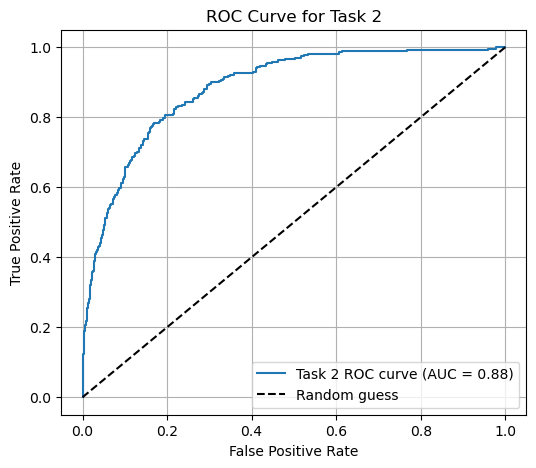

In [7]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_scores, task_index):
    # Compute ROC curve and AUC for a given task
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f'Task {task_index} ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
    plt.title(f'ROC Curve for Task {task_index}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

# Example: Plot ROC curve for a specific task (e.g., task index 0)
def visualize_task_roc(model, loader, task_index=0):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            data.x = data.x.float()  # Ensure correct type
            out = model(data.x, data.edge_index, data.batch)
            preds = torch.sigmoid(out).cpu()
            targets = data.y.cpu()
            all_preds.append(preds)
            all_targets.append(targets)

    all_preds = torch.cat(all_preds, dim=0)
    all_targets = torch.cat(all_targets, dim=0)

    # Mask out missing labels (-1)
    mask = (all_targets != -1)
    valid = mask[:, task_index]
    if valid.sum() > 0:
        y_true = all_targets[valid, task_index].detach().numpy()
        y_scores = all_preds[valid, task_index].detach().numpy()
        plot_roc_curve(y_true, y_scores, task_index)
    else:
        print(f"No valid labels found for task {task_index}.")

# Call the function for task ? (or loop over a few tasks)
visualize_task_roc(model, test_loader, task_index=2)

## Visualizing Embeddings

You can extract embeddings from an intermediate layer and reduce their dimensions for visualization.

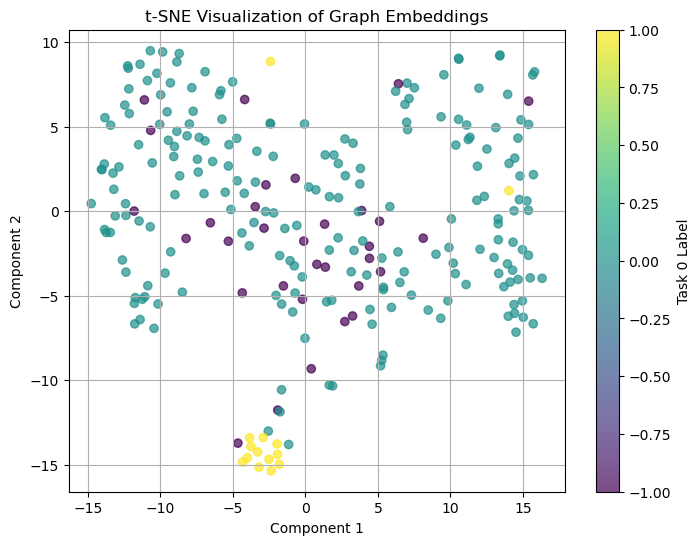

In [8]:
from sklearn.manifold import TSNE

def visualize_embeddings(model, loader, task_index=0, num_samples=200):
    model.eval()
    embeddings = []
    labels = []

    # Collect embeddings for a subset of data
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            data.x = data.x.float()
            # Extract embeddings from the last hidden layer (before classification)
            x = model.conv1(data.x, data.edge_index)
            x = F.relu(x)
            x = model.conv2(x, data.edge_index)
            x = F.relu(x)
            # Global pooling for graph-level representation
            emb = global_mean_pool(x, data.batch)
            embeddings.append(emb.cpu())
            labels.append(data.y.cpu())
            # Limit to a subset for visualization
            if len(embeddings)*data.num_graphs >= num_samples:
                break

    embeddings = torch.cat(embeddings, dim=0)
    labels = torch.cat(labels, dim=0)

    # Use t-SNE to reduce dimensions to 2
    tsne = TSNE(n_components=2)
    embeddings_2d = tsne.fit_transform(embeddings.detach().numpy())

    # For demonstration, color points by the labels of a specific task
    label_task = labels[:, task_index].detach().numpy()

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=label_task, cmap='viridis', alpha=0.7)
    plt.title("t-SNE Visualization of Graph Embeddings")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.colorbar(scatter, label=f"Task {task_index} Label")
    plt.grid(True)
    plt.show()

# Visualize embeddings for task 0 (or adjust task_index as needed)
visualize_embeddings(model, test_loader, task_index=0)

What you see is a two-dimensional scatter plot where each point represents the graph-level embedding (i.e., the learned representation) of a molecule. Each point is colored based on the label of a specific task (for example, one toxicity indicator) from the Tox21 dataset.

## Conclusion

We've:
1. Loaded a real-world molecular dataset (Tox21).
2. Built a **simplified Graphormer** model using `TransformerConv`.
3. Trained it to predict toxicity across multiple tasks.
4. Evaluated performance via **ROC-AUC**.

To further enhance your understanding, you can:
* Experiment with **more layers** or different **hidden dimensions**.
* Add **spatial encodings** (like distances) for a closer match to the original Graphormer approach.
* Compare with a **baseline GCN** or **GAT**.
* Implement **virtual nodes** for graph-level summarization.
* Investigate **attention weights** to interpret how each node influences the final prediction.